In [ ]:
import os

# supported Backends: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
os.environ["DDE_BACKEND"] = "pytorch"


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 5.772826 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.28e+01, 2.66e+00, 0.00e+00, 0.00e+00]    [6.28e+01, 2.66e+00, 0.00e+00, 0.00e+00]    []  
100       [1.04e+01, 6.36e-03, 1.75e-01, 7.82e-04]    [1.04e+01, 6.36e-03, 1.75e-01, 7.82e-04]    []  
200       [6.74e+00, 3.70e-03, 3.68e-04, 1.93e-05]    [6.74e+00, 3.70e-03, 3.68e-04, 1.93e-05]    []  
300       [5.99e+00, 3.10e-03, 3.52e-04, 1.35e-04]    [5.99e+00, 3.10e-03, 3.52e-04, 1.35e-04]    []  
400       [5.79e+00, 1.94e-03, 1.47e-02, 7.01e-05]    [5.79e+00, 1.94e-03, 1.47e-02, 7.01e-05]    []  
500       [5.76e+00, 7.98e-04, 4.85e-03, 3.68e-04]    [5.76e+00, 7.98e-04, 4.85e-03, 3.68e-04]    []  
600       [5.76e+00, 1.24e-03, 1.35e-03, 1.12e-04]    [5.76e+00, 1.24e-03, 1.35e-03, 1.12e-04]    []  
700       [4.88e+00, 3.65e-03, 4.63e-02, 7.36e-04]    [4.88e+00, 3.65e-03, 4.63e-02, 7.36e-04]    []  
8

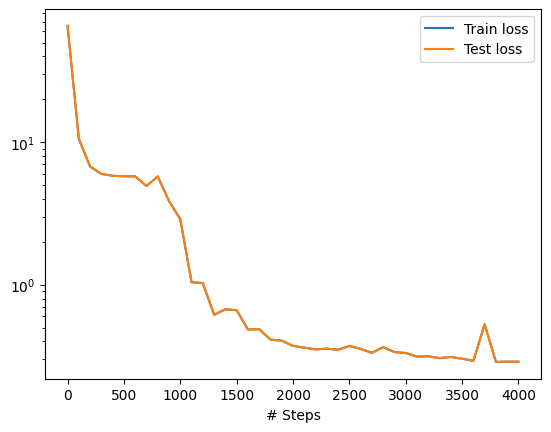

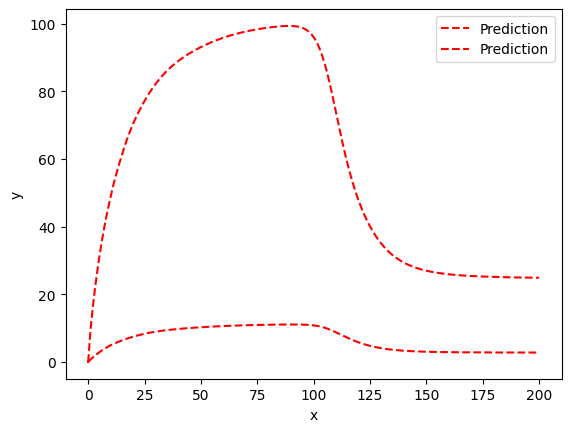

In [ ]:
import deepxde as dde
import numpy as np
import torch


def F(t):
    if type(t) is torch.Tensor:
        return torch.where(t <= 100.0, 10.0, 5.0)
    if type(t) is np.ndarray:
        return np.where(t <= 100.0, 10.0, 5.0)
    return 10.0 if t <= 100.0 else 5.0


c1, c2, A1, A2 = 1.0, 3.0, 1.0, 1.0


def safe_sqrt(x):
    return torch.sqrt(torch.clamp(x, min=0.0001))


def ode_system(x, y):
    h1, h2 = y[:, 0:1], y[:, 1:]

    dh1dt = dde.grad.jacobian(y, x, i=0)
    dh2dt = dde.grad.jacobian(y, x, i=1)

    # Equações
    lossEdo1 = dh1dt - ((F(x) - c1 * safe_sqrt(h1)) / A1)  # type: ignore
    lossEdo2 = dh2dt - ((c1 * safe_sqrt(h1) - c2 * safe_sqrt(h2)) / A2)  # type: ignore

    return [lossEdo1, lossEdo2]


def boundary(_, on_initial):
    return on_initial


X = np.linspace(0, 200, 200)

geom = dde.geometry.TimeDomain(0, 200)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 0, boundary, component=1)
data = dde.data.PDE(
    geom,
    ode_system,
    [ic1, ic2],
    num_domain=100,
    num_boundary=1,
    anchors=X.reshape(-1, 1),
)


layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)  # type: ignore

model = dde.Model(data, net)
model.compile("adam", lr=0.01)
losshistory, train_state = model.train(4000, display_every=100)

dde.saveplot(losshistory, train_state, issave=False)
